## Анализ результатов А/В-теста

#### Задача
- Оценить корректность проведения теста
- Проанализировать результаты теста

Чтобы оценить корректность проведения теста, проверить:
- пересечение тестовой аудитории с конкурирующим тестом,
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

#### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

Содержание
1. [Подготовка данных](#start)
2. [Анализ данных](#analysis)
3. [Вывод](#output)


<a id="start"></a>
### 1. Подготовка данных


In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy import stats as st
import math as mth
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
import datetime 

Откроем и изучим файлы с данными, а также проверим на дубликаты:

**Датасет events** - действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

In [53]:
events = pd.read_csv('/datasets/final_ab_events.csv')
display(events.head())
events.info()
events.duplicated().sum()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
user_id       440317 non-null object
event_dt      440317 non-null object
event_name    440317 non-null object
details       62740 non-null float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


0

В датасете events 4 столбца и 440 317 строк. Пропущенные значения есть только в столбце с дополнительной информацией. Это логично, т.к. возможно, не по каждому пункту есть дополнительная информация. Дубликатов нет. Типы данных: "строчные" и "вещественные числа". Это корректно, кроме столбца с датой. Необходимо изменить тип данных столбца с датой event_dt.

Названия столбцов:
- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

Изменим тип данных столбца с датой на временной

In [54]:
events['event_dt'] = pd.to_datetime(events['event_dt'])

Добавим столбец только с датой

In [55]:
events['event_date'] = events['event_dt'].dt.date
events['event_date'] = pd.to_datetime(events['event_date'])
#events.head()
#events.info()

**Датасет marketing events** - календарь маркетинговых событий на 2020 год.

In [56]:
marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
display(marketing_events)
marketing_events.info()
marketing_events.duplicated().sum()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
name         14 non-null object
regions      14 non-null object
start_dt     14 non-null object
finish_dt    14 non-null object
dtypes: object(4)
memory usage: 576.0+ bytes


0

В датасете marketing_events 4 столбца и 14 строк. Нет пропущенных значений и дубликатов. Тип данных: "строчный". Это некорректно для столбцов с датой. Необходимо изменить тип данных столбцов с датой start_dt и finish_dt.

Названия столбцов:
- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

Изменим тип данных столбцов с датой на временной

In [57]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

**Датасет users** - пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

In [58]:
users = pd.read_csv('/datasets/final_ab_new_users.csv')
display(users.head())
users.info()
users.duplicated().sum()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
user_id       61733 non-null object
first_date    61733 non-null object
region        61733 non-null object
device        61733 non-null object
dtypes: object(4)
memory usage: 1.9+ MB


0

В датасете users 4 столбца и 61 733 строки. Нет пропущенных значений и дубликатов. Тип данных: "строчный". Это некорректно для столбца с датой. Необходимо изменить тип данных столбца с датой first_date.

Названия столбцов:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация

Изменим тип данных столбцов с датой на временной

In [59]:
users['first_date'] = pd.to_datetime(users['first_date'])
#users.info()

**Датасет participants** -  таблица участников тестов.

In [60]:
participants = pd.read_csv('/datasets/final_ab_participants.csv')
display(participants.head())
participants.info()
participants.duplicated().sum()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
user_id    18268 non-null object
group      18268 non-null object
ab_test    18268 non-null object
dtypes: object(3)
memory usage: 428.3+ KB


0

В датасете users 3 столбца и 18 268 строк. Нет пропущенных значений и дубликатов. Тип данных: "строчный". Это корректно для всех столбцов.

Названия столбцов:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

Предоставленные данные достаточно чистые, без дубликатов и пропусков. Мы только изменили тип данных на временной для столбцов с датами.

<a id="analysis"></a>
### 2. Анализ данных


**_A. Исследовательский анализ данных._**

Объединим все данные, кроме таблицы с маркетинговыми активностями, в общий датасет

In [61]:
data = events.merge(users, on='user_id', how='left').merge(participants, on='user_id', how='left')
display(data.head())
data.info()

,user_id,event_dt,event_name,details,event_date,first_date,region,device,group,ab_test
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07,2020-12-07,N.America,iPhone,NaN,NaN
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07,2020-12-07,EU,iPhone,NaN,NaN
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07,2020-12-07,N.America,iPhone,NaN,NaN
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,2020-12-07,EU,iPhone,B,interface_eu_test
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07,2020-12-07,EU,Android,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 446211 entries, 0 to 446210
Data columns (total 10 columns):
user_id       446211 non-null object
event_dt      446211 non-null datetime64[ns]
event_name    446211 non-null object
details       63588 non-null float64
event_date    446211 non-null datetime64[ns]
first_date    446211 non-null datetime64[ns]
region        446211 non-null object
device        446211 non-null object
group         106625 non-null object
ab_test       106625 non-null object
dtypes: datetime64[ns](3), float64(1), object(6)
memory usage: 37.4+ MB


_Проверим данные на аномальные значения._



Выясним, сколько пользователей в каждой экспериментальной группе.

In [62]:
group_count = data.pivot_table(index='group', 
                               values='user_id', 
                               aggfunc={'user_id': 'nunique'}).reset_index()
display(group_count)


,group,user_id
0,A,7874
1,B,6205


Количество пользователей распределено по группам неравномерно. Разница составляет около 22%. Это может существенно повлиять на результаты теста, **поскольку одним из критериев корректного теста является разница между количеством пользователей в тестовых группы в размере не более 1%. Любое увеличение метрик в большей группе может произойти не из-за успешности тестируемых изменений, а из-за большего количества пользователей.**

Проверим пересечение тестовой аудитории с конкурирующим тестом. У нас должны быть результаты только по тесту recommender_system_test.

In [63]:
data['ab_test'].nunique()


2

Мы видим, что в столбце с названием тестирования есть два наименования вместо одного.

Проверим, сколько пользователей попало с другого тестирования.

In [64]:
data['ab_test'].value_counts()

interface_eu_test          81927
recommender_system_test    24698
Name: ab_test, dtype: int64

В нашем датасете около 80%  данных относятся к другому тестированию - interface_eu_test. Их необходимо удалить.

Проверим пересечение тестов interface_eu_test и recommender_system_test по одному и тому же пользователю.

In [65]:
data_check = data.groupby(['user_id']).agg({'ab_test':'nunique'}).reset_index()
ab_test_1 = data_check.query('ab_test == "2"')
display(ab_test_1) 

,user_id,ab_test
14,001064FEAAB631A1,2
50,00341D8401F0F665,2
117,0082295A41A867B5,2
201,00E68F103C66C1F7,2
207,00EFA157F7B6E1C4,2
...,...,...
58395,FEA0C585A53E7027,2
58426,FEC0BCA6C323872F,2
58514,FF2174A1AA0EAD20,2
58543,FF44696E39039D29,2


Проверка показала, что 887 пользователей участвовало в двух тестах одновременно interface_eu_test и recommender_system_test. Это может также существенно исказить результаты. Будет неясно, какое именно тестирование повлияло на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно. 

Создаем новый датасет только с одним тестированием.

In [66]:
data_new = data[(data['ab_test'] == 'recommender_system_test')]
data_new.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 24698 entries, 5 to 446183
Data columns (total 10 columns):
user_id       24698 non-null object
event_dt      24698 non-null datetime64[ns]
event_name    24698 non-null object
details       3331 non-null float64
event_date    24698 non-null datetime64[ns]
first_date    24698 non-null datetime64[ns]
region        24698 non-null object
device        24698 non-null object
group         24698 non-null object
ab_test       24698 non-null object
dtypes: datetime64[ns](3), float64(1), object(6)
memory usage: 2.1+ MB


Узнаем, сколько уникальных пользователей в датасете.

In [67]:
users_total = data_new['user_id'].nunique()
print(f'Всего пользователей: ', users_total)


Всего пользователей:  3675


Снова проверим распределение пользователей группам, но уже по очищенным данным.

In [68]:
group_count_new = data_new.pivot_table(index='group', 
                               values='user_id', 
                               aggfunc={'user_id': 'nunique'}).reset_index()
display(group_count_new)

,group,user_id
0,A,2747
1,B,928


Разница в количестве пользователей увеличилась - в группе В на 66% пользователей меньше. Это сильно повлияет на результат теста.

Сколько событий приходится на одного пользователя в среднем?

In [69]:
event_mean = data_new.groupby('user_id')['event_name'].count().mean().round(2)
print(f'Среднее количество событий на одного пользователя:', event_mean)


Среднее количество событий на одного пользователя: 6.72


Проверим, как распределено количество событий на пользователя в тестовых выборках.



In [70]:
event_mean_A = data_new.query('group == "A"').groupby('user_id')['event_name'].count().mean().round(2)
print(f'Среднее количество событий на одного пользователя в группе А:', event_mean_A)

event_mean_B = data_new.query('group == "B"').groupby('user_id')['event_name'].count().mean().round(2)
print(f'Среднее количество событий на одного пользователя в группе B:', event_mean_B)


Среднее количество событий на одного пользователя в группе А: 7.03
Среднее количество событий на одного пользователя в группе B: 5.81


В обеих группах среднее количество событий на одного пользователя различно - 7,03 в группе А и 5,81 в группе В. Значит события распределены неравномерно.

_Как число событий распределено по дням?_

Узнаем, сколько в среднем событий происходит в день.

In [71]:
event_day = data_new.groupby('event_date')['event_name'].count().mean().round(0)
print(f'Среднее количество событий в день:', event_day)

Среднее количество событий в день: 1029.0


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



Text(0, 0.5, 'количество событий')

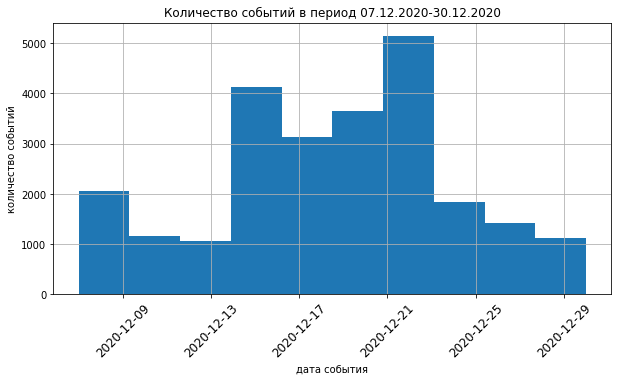

In [72]:
fig, ax = plt.subplots(figsize=(10,5))
data_new['event_date'].hist()
ax.tick_params(axis='x', labelsize = 12, labelrotation=45)
plt.title('Количество событий в период 07.12.2020-30.12.2020')
plt.xlabel("дата события")
plt.ylabel("количество событий")


В начале тестирования 7-8.12 число событий увеличивается и составляет 2 тыс. в день. Наибольшое количество событий происходило в период с 20-23.12.2020 (5 тыс.), а также 14-16.12.2020 (4 тыс.). После 23.12. количество событий сокращается - от 2 тыс. до среднего показателя за период - 1 тыс.

Основной пик активности - 13-23.12.2020, т.е. на 5-й и 16-й день после регистрации пользователя.

Судя по графику, нет данных за 4 дня в январе 2021 г. Уточним максимальную и минимальную дату, хотя период нам был известен при получении информации.

In [73]:
data_new['event_date'].max()

Timestamp('2020-12-30 00:00:00')

In [74]:
data_new['event_date'].min()

Timestamp('2020-12-07 00:00:00')

Мы видим, что у нас данные с 07.12.20 по 30.12.2020. Хотя тест был остановлен 04.01.2021. Возможно, событий не было из-за новогодних праздников с 30.12 по 04.01.

Также необходимо проверить совпадения периода теста с другими маркетинговыми событиями в этот же период.

In [75]:
other_events = marketing_events[(marketing_events['start_dt'] >= pd.Timestamp(2020,12,7)) & (marketing_events['start_dt'] <= pd.Timestamp(2020,12,30))]
display(other_events)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Есть одно совпадение по активностям в тестируемом регионе EU: 25.12.2020-03.01.2021 - промоакция на Рождество и Новый Год.

Хотя в данный период не наблюдается увеличение активности пользователей, тем не менее, мы не можем быть уверены, что 1-2 тыс.событий происходили бы и без влияния промоакции. Поэтому результаты теста в данный период могут быть под сомнением.

_Рассмотрим __воронку событий__,  чтобы понять, как меняется конверсия на разных этапах?_

Посмотрим, какие события есть в датасете и их градацию по количеству

In [76]:
event_count = data_new['event_name'].count()
print(f'Общее количество событий:', event_count)

Общее количество событий: 24698


In [77]:
display(data_new['event_name'].value_counts())

login           11190
product_page     6930
purchase         3331
product_cart     3247
Name: event_name, dtype: int64

В датасете есть 4 вида событий: _вход на сайт, просмотр карточки товара, покупка, просмотр корзины_. Градация частоты событий последовательна и логична. За исключением того, что немного чаще покупают товар, минуя этап просмотра корзины. Возможно, это происходит в случае покупки только одной единицы товара.

Построим продуктовую воронку с учётом следующей последовательности событий:

- вход на сайт
- просмотр карточки товара
- покупка
- просмотр корзины


Построим график воронки

In [102]:
fig = go.Figure(
go.Funnel(
      y = [
         "Вход на сайт", 
         "Просмотр карточки товара", 
         "Оплата товара",
         "Добавление в корзину"],
      x = [11190, 6930, 3331, 3247],
      opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"],
    }
  )
)
fig.update_layout(title="Продуктовая воронка с учетом последовательности событий")
fig.show()


Таким образом, продуктовая воронка с учетом последовательности событий выглядит следующим образом:

- Зашли на сайт: 11 190
- Просмотрели карточку товара: 6 930 (61,9% от посетителей)
- Оплатили: 3 331 (48,1% от тех, кто просмотрел карточку товара)
- Добавили в корзину: 3 247 (97,5% от оплативших)


Больше всего мы теряем пользователей на этапе "Покупки", около 51,9% от просмотревших товары. На этапе "Просмотра товара" теряем 38,1% от посетителей. В свою очередь, в корзину не добавляют только 2,5% от тех, кто уже сделал покупку. Возможно, большинство покупок совершается по прямым ссылкам с других источников.
До оплаты доходит 29% пользователей от первого события - "Просмотр главной страницы". 


По обеим группам посчитаем, сколько пользователей совершали каждое из этих событий и какова их доля по каждому событию.

**Расчет для группы А**

In [85]:
users_count_А = data_new.query('group == "A"').groupby(['event_name']).agg({'user_id': 'nunique'}).reset_index()
users_count_А['mean'] = users_count_А['user_id'] / group_count_new['user_id'][0]
users_count_А.columns = ['event', 'user_id_A', 'mean_A']
users_count_А = users_count_А.sort_values(by = 'user_id_A', ascending=False).reset_index(drop=True)
display(users_count_А)


,event,user_id_A,mean_A
0,login,2747,1.000000
1,product_page,1780,0.647980
2,purchase,872,0.317437
3,product_cart,824,0.299964


**Расчет для группы В**

In [86]:
users_count_B = data_new.query('group == "B"').groupby(['event_name']).agg({'user_id': 'nunique'}).reset_index()
users_count_B['mean'] = users_count_B['user_id'] / group_count_new['user_id'][1]
users_count_B.columns = ['event', 'user_id_B', 'mean_B']
users_count_B = users_count_B.sort_values(by = 'user_id_B', ascending=False).reset_index(drop=True)
display(users_count_B)

,event,user_id_B,mean_B
0,login,928,1.000000
1,product_page,523,0.563578
2,purchase,256,0.275862
3,product_cart,255,0.274784


Построим _сравнительную продуктовую воронку_ по обеим группам

In [101]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = ["Вход на сайт", 
         "Просмотр карточки товара",
         "Оплата товара",
         "Добавление в корзину"],
    x = [2747, 1780, 872, 824],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'B',
    orientation = "h",
    y = ["Вход на сайт", 
         "Просмотр карточки товара", 
         "Оплата товара",
         "Добавление в корзину"],
    x = [928, 523, 256, 255],
    textposition = "inside",
    textinfo = "value+percent initial"))
fig.update_layout(title="Продуктовая воронка тестовых групп A и B")
fig.show()


Доли от общего числа пользователей по всем этапам отличаются. В группе А доля событий выше на всех этапах:
- "Просмотр карточки товара" - 65% и 56% соответственно. Снижение конверсии на 11% в группе В
- "Просмотр корзины" - 32% и 28%. Снижение конверсии на 4% в группе В
- "Покупка" - 30% и 27%. Снижение конверсии на 3% в группе В

Если сравнивать доли переходящих на следующие этапы от числа предыдущего этапа, то не изменился по значениям этап "Покупка" (49% от просмотревших товар в обеих группах).

Ожидаемого эффекта не произошло, метрики должны были улучшиться на 10%, но они ухудшились на 3-9%.

_Выясним, присутствуют ли в выборках одни и те же пользователи?_

1 способ: поищем пользователей по фильтру принадлежности обеим группам.

In [88]:
two_group_1 = data_new.query('group == "A" and group == "B"').count()
display(two_group_1)

user_id       0
event_dt      0
event_name    0
details       0
event_date    0
first_date    0
region        0
device        0
group         0
ab_test       0
dtype: int64

2 способ: проверим каждого пользователя на уникальные значения группы. У каждого должно быть по одной группе. Если суммировать все данные по группам, то ответ будет равен количеству уникальных пользователей в датасете - 3 675.

In [89]:
two_group_2 = data_new.groupby(['user_id']).agg({'group': 'nunique'}).sum()
display(two_group_2)

group    3675
dtype: int64

В выборках нет одних и тех же пользователей, т.к. сумма уникальных значений групп равна количеству уникальных пользователей - 3 675.

Мы определили, что в данных есть аномальные значения: 80% инфомации из другого тестирования. Также обнаружено около 800 пользователей, участвоваших в двух разных тестах одновременно, что может подвергнуть результаты теста сомнению, т.к. неясно, какой именно тест повлиял на решения пользователей.
После удаления аномалий у нас осталось 24 698 событий и 3 675 пользователей. 

Среднее количество событий на одного пользователя: 6.72, а в тестовых группах А и В по 7.03 и 5.81 соответственно. 
  
Ср.количество событий в день: 1 029.

Данные предоставлены за период с 07.12.2020 по 04.01.2021, но обнаружено, что нет данных с 31.12.2020 по 04.01.2021. Возможно, событий в этот период не было.
 
В начале тестирования 7-8.12 число событий увеличивается и составляет 2 тыс. в день. Наибольшое количество событий происходило в период с 20-23.12.2020 (5 тыс.), а также 14-16.12.2020 (4 тыс.). После 23.12. количество событий сокращается - от 2 тыс. до среднего показателя за период - 1 тыс.
Основной пик активности - 13-23.12.2020, т.е. на 5-й и 16-й день после регистрации пользователя.

Есть одно совпадение по активностям в тестируемом регионе EU: 25.12.2020-03.01.2021 - промоакция на Рождество и Новый Год. Хотя в данный период не наблюдается увеличение активности пользователей, тем не менее, мы не можем быть уверены, что 1-2 тыс.событий происходили бы и без влияния промоакции. Поэтому результаты теста в данный период могут быть под сомнением.

В датасете есть 4 вида событий: _вход на сайт, просмотр карточки товара, покупка, просмотр корзины_. Градация частоты событий последовательна и логична. За исключением того, что немного чаще покупают товар, минуя этап просмотра корзины. Возможно, это происходит в случае покупки только одной единицы товара.

Таким образом, продуктовая воронка с учетом последовательности событий выглядит следующим образом:

Зашли на сайт: 11 190
Просмотрели карточку товара: 6 930 (61,9% от посетителей)
Оплатили: 3 331 (48,1% от тех, кто просмотрел карточку товара)
Добавили в корзину: 3 247 (97,5% от оплативших)

Больше всего мы теряем пользователей на этапе "Покупки", около 51,9% от просмотревших товары. На этапе "Просмотра товара" теряем 38,1% от посетителей. В свою очередь, в корзину не добавляют только 2,5% от тех, кто уже сделал покупку. Возможно, большинство покупок совершается по прямым ссылкам с других источников. До оплаты доходит 29% пользователей от первого события - "Просмотр главной страницы".

Разница в количестве пользователей между группами составляет 66%, что может исказить результаты тестировани, поскольку одним из критериев корректного теста является разница между количеством пользователей в тестовых группы в размере не более 1%. Любое увеличение метрик в большей группе может произойти не из-за успешности тестируемых изменений, а из-за большего количества пользователей.

Доли от общего числа пользователей по всем этапам отличаются. В группе А доля событий выше на всех этапах:
- "Просмотр карточки товара" - 65% и 56% соответственно. Снижение конверсии на 11% в группе В
- "Просмотр корзины" - 32% и 28%. Снижение конверсии на 4% в группе В
- "Покупка" - 30% и 27%. Снижение конверсии на 3% в группе В

Если сравнивать доли переходящих на следующие этапы от числа предыдущего этапа, то не изменился по значениям этап "Покупка" (49% от просмотревших товар в обеих группах).

Можно сделать вывод, что ожидаемого эффекта не произошло, метрики должны были улучшиться на 10%, но они ухудшились на 3-9%.

**_В. Оценка результатов A/B-тестирования_**

__1. Оценка корректности проведения теста.__

Тест проведен не совсем корректно по следующим критериям:
- Количество пользователей в различных группах различается более, чем на 1% - пользователей в группе В меньше на 66%.
- Время проведения теста совпало с другим маркетинговым мероприятияем - промоакцией на Рождество и Новый Год (25.12.2020-03.01.2021). 
- Размер выборки: не выполнено условие по ожидаемому количеству участников теста: из предполагаемых 6000 участвовало 3 675 (61%). Возможно, из-за того, что тестирование совпало с новогодними праздниками, количество участников не набралось. 

__2.Проверка гипотез (тест А/В)__

Проверим гипотезы улучшения метрик по трем событиям.

_a) Конверсия в "Просмотр карточки товара"_

В группе А: 1 780 пользователей / 65%
В группе В:   523 пользователя / 56%

Теперь необходимо проверить будет ли отличие между группами по доле пользователей в данном событии статистически достоверным.

Нам необходимо проверить гипотезу о равенстве долей. Если некоторая доля генеральной совокупности обладает признаком, а другая её часть — нет, об этой доле можно судить по выборке из генеральной совокупности. Выборочные доли будут нормально распределены вокруг настоящей.

Проверим гипотезу, что по событию "Просмотр главной страницы" доли обеих групп А и В равны друг другу.

Формируем нулевую гипотезу:
H₀ = "доля группы А равна доле группы В"¶.
Из H₀ формулируем альтернативную гипотезу: H₁ = "доля группы А не равна доле группы В".
Уровень статистической значимости установим 5%.

In [90]:
alpha = .05 

successes = np.array([1780, 523])
trials = np.array([2747, 928])

p1 = successes[0]/trials[0]
p2 = successes[1]/trials[1]

p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
difference = p1 - p2
display(difference)


0.08440202791760287

Если доли были бы равны, то разница между ними должна была быть равна нулю. Считаем статистику в стандартных отклонениях стандартного нормального распределения с заданными параметрами (среднее 0, ст.отклонение 1)

Проверим статистическую разницу z-критерием.

In [91]:
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
distr = st.norm(0, 1)
display(z_value)

4.595797095745397

Так как распределение статистики нормальное, вызовем метод cdf(). Тест двусторонний, поэтому возьмем статистику по модулю методом abs() и удваиваем результат.

In [92]:
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")


p-значение:  4.310980554755872e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница


р-value ниже уровня значимости 0.05, поэтому 'отвергаем нулевую гипотезу: между долями есть значимая разница'. Мы получили подтверждение, что доли групп А и В статистически также не равны. Мы указываем, что различия достоверны на 5%-ом уровне значимости, т.е. вероятность того, что они все-таки недостоверны, составляет 0,05.

Объединим данные по количеству пользователей и конверсии обеих групп в одну таблицу.

In [93]:
total_count = users_count_А.merge(users_count_B, on='event').sort_values(by='user_id_A', ascending=False).reset_index(drop=True)
display(total_count)


,event,user_id_A,mean_A,user_id_B,mean_B
0,login,2747,1.000000,928,1.000000
1,product_page,1780,0.647980,523,0.563578
2,purchase,872,0.317437,256,0.275862
3,product_cart,824,0.299964,255,0.274784


Напишем функцию по проверке остальных гипотез

In [94]:
def hyp_check (successes_p1, trials_p1, successes_p2, trials_p2, alpha):
    
    alpha = alpha 
         
    p1 = successes_p1/trials_p1
    p2 = successes_p2/trials_p2
    
    p_combined = (successes_p1 + successes_p2) / (trials_p1 + trials_p2)
    
    difference = p1 - p2
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials_p1 + 1/ trials_p2))
    
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")


_b) Конверсия в "Просмотр корзины"_

Проверим гипотезу, что по событию "Просмотр корзины" доли обеих групп А и В равны друг другу.

In [95]:
hyp_check(np.array(total_count['user_id_A'])[3],
          np.array(group_count['user_id'])[0],
          np.array(total_count['user_id_B'])[3],
          np.array(group_count['user_id'])[1],
          0.05)


p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


_c) Конверсия в "Покупку товара"_

Проверим гипотезу, что по событию "Покупка товара" доли обеих групп А и В равны друг другу.

In [96]:
hyp_check(np.array(total_count['user_id_A'])[2],
          np.array(group_count['user_id'])[0],
          np.array(total_count['user_id_B'])[2],
          np.array(group_count['user_id'])[1],
          0.05)

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


Оценка критериев проведения теста показывает, что тест проведен некорректно по нескольким пунктам, поэтому его результаты могут быть неверны.

Все эксперименты подтверждают, что доли обеих контрольных выборок А и В статистически не равны по всем событиям. Мы не можем сказать, что разбиение на группы работает корректно. Если две тестовые группы не равны, мы не можем быть уверены в точности проведенного тестирования.

Из этого следует, что мы пока точно не можем сказать об изменениях в лояльности пользователей, связанных с внедрением улучшенной рекомендательной системы. Предварительно, улучшения не произошло, более того, по всем метрикам показатели ухудшились.

<a id="output"></a>
### 3. Вывод


По результатам анализа предоставленных данных можно сделать следующие выводы:

**I. Исследовательский анализ данных:**

_1. Основные результаты анализа данных_

- удалено 80% данных, т.к. выявлены аномалии по пересечению с другим тестированием;
- обнаружена существенная разница между количеством пользователей в группах - около 66%;
- найдено одно совпадение по активностям в тестируемом регионе EU: 25.12.2020-03.01.2021 - промоакция на Рождество и Новый Год, это может повлиять на результаты теста;
- всего 24 698 событий;
- всего  3 675 пользователей;
- среднее количество событий в день: 1 029;
- среднее количество событий на одного пользователя: 6.72, а в тестовых группах А и В по 7.03 и 5.81 соответственно;
- данные предоставлены за период с 07.12.2020 по 04.01.2021, но обнаружено, что нет данных с 31.12.2020 по 04.01.2021. Возможно, событий в этот период не было по причине новогодних праздников.
- основной пик активности пользователей по количеству событий - 13-23.12.2020, т.е. на 5-й и 16-й день после регистрации пользователя - 4-5 тыс.событий в день. После 23.12. количество событий сокращается до среднего показателя за период - 1 тыс., но мы не можем быть уверены, что 1 тыс.событий происходили бы и без влияния промоакции. Поэтому результаты теста в данный период могут быть под сомнением;

- в датасете есть 4 вида событий: _вход на сайт, просмотр карточки товара, покупка, просмотр корзины_. Градация частоты событий последовательна и логична. За исключением того, что немного чаще покупают товар, минуя этап просмотра корзины. Возможно, это происходит в случае покупки только одной единицы товара.

_2.Продуктовая воронка_

- общая продуктовая воронка событий выглядит следующим образом:
   * Зашли на сайт: 11 190;
   * Просмотрели карточку товара: 6 930 (61,9% от посетителей);
   * Оплатили: 3 331 (48,1% от тех, кто просмотрел карточку товара);
   * Добавили в корзину: 3 247 (97,5% от оплативших)

Больше всего мы теряем пользователей на этапе "Покупки", около 51,9% от просмотревших товары. На этапе "Просмотра товара" теряем 38,1% от посетителей. В свою очередь, в корзину не добавляют только 2,5% от тех, кто уже сделал покупку. Возможно, большинство покупок совершается по прямым ссылкам с других источников.
До оплаты доходит 29% пользователей от первого события - "Просмотр главной страницы". 


- сравнение продуктовой воронки по группам А и В:
    * "Просмотр карточки товара" - 65% и 56% соответственно. Снижение конверсии на 11% в группе В;
    * "Просмотр корзины" - 32% и 28%. Снижение конверсии на 4% в группе В;
    * "Покупка" - 30% и 27%. Снижение конверсии на 3% в группе В.
    
В обеих группах доли от общего числа пользователей по всем этапам отличаются. В группе А доля событий выше на всех этапах.
Можно сделать вывод, что ожидаемого эффекта не произошло, метрики должны были улучшиться на 10%, но они ухудшились на 3-9%.

**II. Оценка результатов A/B-тестирования:**

_1. Оценка корректности проведения теста_ 

Тест проведен не совсем корректно по следующим критериям:
- Количество пользователей в различных группах различается более, чем на 1% - пользователей в группе В меньше на 66%.
- Время проведения теста совпало с другим маркетинговым мероприятияем - промоакцией на Рождество и Новый Год (25.12.2020-03.01.2021). 
- Размер выборки: не выполнено условие по ожидаемому количеству участников теста: из предполагаемых 6000 участвовало 3 675 (61%). Возможно, из-за того, что тестирование совпало с новогодними праздниками, количество участников не набралось. 

_2.Проверка гипотез_

Статистическая разница долей трех основных событий ("Просмотр карточки товара", "Добавление в корзину" и "Покупка товара") проверена с помощью z-критерием. Все эксперименты подтверждают, что доли обеих контрольных выборок А и В статистически не равны по всем событиям. Мы не можем сказать, что разбиение на группы работает корректно. Если две тестовые группы не равны, мы не можем быть уверены в точности проведенного тестирования.

Из этого следует, что мы пока точно не можем сказать об изменениях в лояльности пользователей, связанных с внедрением улучшенной рекомендательной системы. Предварительно, улучшения не произошло, более того, по всем метрикам показатели ухудшились.